# Topic Modeling with Google Colab, Gensim and Mallet

This notebook implements [Gensim](https://radimrehurek.com/gensim/) and [Mallet](http://mallet.cs.umass.edu/index.php) for topic modeling using the [Google Colab](https://colab.research.google.com/) platform. The README is available at the [Colab + Gensim + Mallet Github repository](https://github.com/polsci/colab-gensim-mallet).

## Upgrade Gensim

In [1]:
!pip install --upgrade gensim

     |████████████████████████████████| 24.2MB 99.6MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


## Install Java

In [2]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.4" 2019-07-16
OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3)
OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)


## Install Mallet

In [3]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2019-10-02 08:27:19--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  7.06MB/s    in 2.2s    

2019-10-02 08:27:22 (7.06 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

## Upload and extract corpus

Upload a zip file with your corpus. The zip file of the corpus should contain a single directory containing .txt files. It appears that you need to rerun the cell if you don't select the file within a set time. 

In [4]:
import zipfile
from google.colab import files

uploaded = files.upload()

Saving ted-transcripts.zip to ted-transcripts.zip


This assumes you have uploaded a file above! This will output a directory listing as well so you can see your uploaded file and the directory.

In [5]:
path_to_zip_file = list(uploaded.keys())[0]

print ('Extracting',path_to_zip_file)

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
  zip_ref.extractall('.')

print()
print('Here is a directory listing (you should see a directory with your corpus):')
!ls -l

Extracting ted-transcripts.zip

Here is a directory listing (you should see a directory with your corpus):
total 32228
drwxr-xr-x 10 root root     4096 Nov 14  2016 mallet-2.0.8
-rw-r--r--  1 root root 16184794 Nov 14  2016 mallet-2.0.8.zip
drwxr-xr-x  1 root root     4096 Aug 27 16:17 sample_data
-rw-r--r--  1 root root 16416075 Oct  2 08:30 ted-transcripts.zip
drwxr-xr-x  2 root root   389120 Oct  2 08:31 transcripts


## Import required libraries for topic modeling

In [6]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim import similarities

import os.path
import re
import glob

import nltk
nltk.download('stopwords')

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Set the path to the Mallet binary and set the path to the corpus

In [0]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 
corpus_path = 'transcripts' # you need to change this path to the directory containing your corpus of .txt files

## Functions to load and preprocess the corpus and create the document-term matrix

The following cell contains functions to load a corpus from a directory of text files, preprocess the corpus and create the bag of words document-term matrix. 

In [0]:
def load_data_from_dir(path):
    file_list = glob.glob(path + '/*.txt')

    # create document list:
    documents_list = []
    source_list = []
    for filename in file_list:
        with open(filename, 'r', encoding='utf8') as f:
            text = f.read()
            f.close()
            documents_list.append(text)
            source_list.append(os.path.basename(filename))
    print("Total Number of Documents:",len(documents_list))
    return documents_list, source_list

def preprocess_data(doc_set,extra_stopwords = {}):
    # adapted from https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python
    # replace all newlines or multiple sequences of spaces with a standard space
    doc_set = [re.sub('\s+', ' ', doc) for doc in doc_set]
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # add any extra stopwords
    if (len(extra_stopwords) > 0):
        en_stop = en_stop.union(extra_stopwords)
    
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # add tokens to list
        texts.append(stopped_tokens)
    return texts

def prepare_corpus(doc_clean):
    # adapted from https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

## Load and pre-process the corpus
Load the corpus, preprocess with additional stop words and output dictionary and document-term matrix.

In [9]:
# adjust the path below to wherever you have the transcripts2018 folder
document_list, source_list = load_data_from_dir(corpus_path)

# I've added extra stopwords here in addition to NLTK's stopword list - you could look at adding others.
doc_clean = preprocess_data(document_list,{'laughter','applause','guy', 'guys', 'yeah', 'stuff'})
dictionary, doc_term_matrix = prepare_corpus(doc_clean)

Total Number of Documents: 3603


## LDA model with 30 topics
The following cell sets the number of topics we are training the model for. 

In [0]:
number_of_topics=30 # adjust this to alter the number of topics
words=20 #adjust this to alter the number of words output for the topic below

The following cell runs LDA using Mallet from Gensim using the number_of_topics specified above. This might take a few minutes! 

In [0]:
ldamallet30 = LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=number_of_topics, id2word=dictionary)

The following cell outputs the topics.

In [26]:
ldamallet30.show_topics(num_topics=number_of_topics,num_words=words)

[(0,
  '0.028*"health" + 0.019*"cancer" + 0.016*"disease" + 0.016*"care" + 0.014*"medical" + 0.014*"patients" + 0.012*"heart" + 0.011*"patient" + 0.009*"drug" + 0.009*"drugs" + 0.009*"treatment" + 0.009*"doctors" + 0.008*"blood" + 0.008*"doctor" + 0.008*"hospital" + 0.008*"medicine" + 0.007*"hiv" + 0.006*"surgery" + 0.005*"diseases" + 0.005*"research"'),
 (1,
  '0.041*"food" + 0.033*"water" + 0.013*"eat" + 0.011*"plant" + 0.010*"plants" + 0.009*"trees" + 0.007*"forest" + 0.007*"grow" + 0.006*"plastic" + 0.006*"soil" + 0.006*"feed" + 0.006*"farmers" + 0.006*"eating" + 0.006*"growing" + 0.005*"tree" + 0.005*"waste" + 0.005*"bees" + 0.005*"sugar" + 0.004*"agriculture" + 0.004*"nature"'),
 (2,
  '0.033*"earth" + 0.022*"planet" + 0.018*"water" + 0.013*"space" + 0.012*"ice" + 0.009*"surface" + 0.009*"mars" + 0.008*"system" + 0.008*"moon" + 0.007*"sun" + 0.007*"ocean" + 0.007*"place" + 0.006*"deep" + 0.006*"atmosphere" + 0.005*"cold" + 0.005*"miles" + 0.005*"sea" + 0.005*"mountain" + 0.004*"s

## Convert to Gensim model format
Convert the Mallet model to Gensim format.

In [0]:
gensimmodel30 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet30)

## Get a coherence score

In [0]:
coherencemodel = CoherenceModel(model=gensimmodel30, texts=doc_clean, dictionary=dictionary, coherence='c_v')
print (coherencemodel.get_coherence())

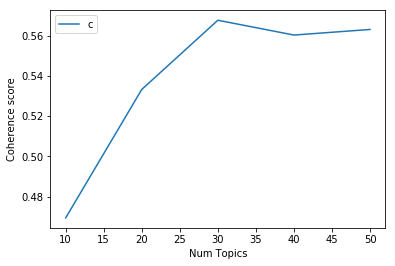

Num Topics = 10  has Coherence Value of 0.4694
Num Topics = 20  has Coherence Value of 0.5333
Num Topics = 30  has Coherence Value of 0.5677
Num Topics = 40  has Coherence Value of 0.5603
Num Topics = 50  has Coherence Value of 0.5631


In [15]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    """
    
    coherence_values = []
    model_list = []
    for number_of_topics in range(start, limit, step):
        model=LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=number_of_topics, id2word=dictionary)
        gensimmodel = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model)
        model_list.append(gensimmodel)
        coherencemodel = CoherenceModel(model=gensimmodel, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=doc_clean, start=10, limit=51, step=10)
# Show graph
import matplotlib.pyplot as plt
limit=51; start=10; step=10;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#print the coherence score
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

## Get id for specific videos

In [32]:
lookup_doc_id = source_list.index('2010-07-15-tim_jackson_s_economic_reality_check.txt')
print('Document ID from lookup:', lookup_doc_id)

Document ID from lookup: 1905


## Preview a document

Preview a document - you can change the doc_id to view another document.

In [33]:
doc_id = lookup_doc_id # index of document to explore - this can be an id number or set to lookup_doc_id
print(re.sub('\s+', ' ', document_list[doc_id])) 

I want to talk to you today about prosperity, about our hopes for a shared and lasting prosperity. And not just us, but the two billion people worldwide who are still chronically undernourished. And hope actually is at the heart of this. In fact, the Latin word for hope is at the heart of the word prosperity. "Pro-speras," "speras," hope — in accordance with our hopes and expectations. The irony is, though, that we have cashed-out prosperity almost literally in terms of money and economic growth. And we've grown our economies so much that we now stand in a real danger of undermining hope — running down resources, cutting down rainforests, spilling oil into the Gulf of Mexico, changing the climate — and the only thing that has actually remotely slowed down the relentless rise of carbon emissions over the last two to three decades is recession. And recession, of course, isn't exactly a recipe for hope either, as we're busy finding out. So we're caught in a kind of trap. It's a dilemma, a

## Output the distribution of topics for the document

The next cell outputs the distribution of topics on the document specified above.

In [34]:
document_topics = gensimmodel30.get_document_topics(doc_term_matrix[doc_id])
document_topics = sorted(document_topics, key=lambda x: x[1], reverse=True) # sorts document topics

for topic, prop in document_topics:
    topic_words = [word[0] for word in gensimmodel30.show_topic(topic, 10)]
    print ("%.2f" % prop, topic, topic_words)

0.19 24 ['countries', 'africa', 'country', 'china', 'global', 'percent', 'economic', 'growth', 'india', 'population']
0.12 14 ['money', 'business', 'dollars', 'company', 'companies', 'market', 'buy', 'pay', 'jobs', 'industry']
0.09 9 ['energy', 'climate', 'power', 'ca', 'carbon', 'oil', 'car', 'change', 'cars', 'air']
0.08 13 ['feel', 'love', 'experience', 'feeling', 'fear', 'mind', 'person', 'lives', 'happy', 'live']
0.06 23 ['talk', 'idea', 'bit', 'start', 'thinking', 'talking', 'important', 'thought', 'problem', 'pretty']
0.05 18 ['history', 'century', 'human', 'god', 'culture', 'religion', 'story', 'man', 'religious', 'ancient']
0.04 25 ['political', 'government', 'power', 'country', 'change', 'public', 'states', 'democracy', 'rights', 'united']
0.04 27 ['question', 'study', 'science', 'answer', 'social', 'research', 'group', 'questions', 'evidence', 'wrong']
0.04 19 ['design', 'create', 'technology', 'material', 'process', 'working', 'designed', 'materials', 'idea', 'build']
0.03 

## Find similar documents
This will find the 5 most similar documents to the document specified above based on their topic distribution.

In [35]:
# gensimmodel30[doc_term_matrix] below represents the documents in the corpus in LDA vector space
lda_index = similarities.MatrixSimilarity(gensimmodel30[doc_term_matrix])

# query for our doc_id from above
similarity_index = lda_index[gensimmodel30[doc_term_matrix[doc_id]]]

# Sort the similarity index
similarity_index = sorted(enumerate(similarity_index), key=lambda item: -item[1])

for i in range(1,6): 
    document_id, similarity_score = similarity_index[i]

    print('Document Index:',document_id)
    print('Document:', source_list[document_id])
    print('Similarity Score:',similarity_score)
    
    print(re.sub('\s+', ' ', document_list[document_id][:500]), '...') # preview first 500 characters

    document_topics = gensimmodel30[doc_term_matrix[document_id]]
    document_topics = sorted(document_topics, key=lambda x: x[1], reverse=True)
    for topic, prop in document_topics:
        topic_words = [word[0] for word in gensimmodel30.show_topic(topic, 10)]
        print ("%.2f" % prop, topic, topic_words)
    
    print()

Document Index: 1243
Document: 2009-07-24-geoff_mulgan_post_crash_investing_in_a_better_world_1.txt
Similarity Score: 0.92645067
It's hard to believe that it's less than a year since the extraordinary moment when the finance, the credit, which drives our economies froze. A massive cardiac arrest. The effect, the payback, perhaps, for years of vampire predators like Bernie Madoff, whom we saw earlier. Abuse of steroids, binging and so on. And it's only a few months since governments injected enormous sums of money to try and keep the whole system afloat. And we're now in a very strange sort of twilight zone, where no one q ...
0.23 24 ['countries', 'africa', 'country', 'china', 'global', 'percent', 'economic', 'growth', 'india', 'population']
0.16 14 ['money', 'business', 'dollars', 'company', 'companies', 'market', 'buy', 'pay', 'jobs', 'industry']
0.06 18 ['history', 'century', 'human', 'god', 'culture', 'religion', 'story', 'man', 'religious', 'ancient']
0.06 23 ['talk', 'idea', 'bit